# 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import arff

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap, trustworthiness

from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor

# A. Preprocessing and Initial Setup

Reading `yeast.arff` and converting to `yeast.csv` file.  
```python
data, meta = arff.loadarff("Yeast Mulan/yeast.arff")
df = pd.DataFrame(data)
df = df.map(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)
df.to_csv("yeast.csv", index=False)
```

## 1. Data Loading

In [3]:
df = pd.read_csv('yeast.csv')
print(f"Dataset shape: {df.shape}")
df.sample(5)

Dataset shape: (2417, 117)


Att1      Att2      Att3      Att4      Att5      Att6      Att7  \
1317  0.023168  0.077770  0.105421  0.074980  0.090160  0.177202  0.245775   
1676  0.029016  0.022439  0.072428 -0.030736 -0.033712  0.077871 -0.028415   
1427  0.051243 -0.058362 -0.044705 -0.055591 -0.032861  0.012403 -0.090467   
790  -0.186916  0.001008  0.185030  0.183202  0.101479  0.014619 -0.151978   
287  -0.003134 -0.072304 -0.003076  0.017669  0.117389  0.056155  0.161289   

          Att8      Att9     Att10  ...  Class5  Class6  Class7  Class8  \
1317  0.183908  0.188357  0.160406  ...       0       1       1       0   
1676  0.035083 -0.072134 -0.103198  ...       0       0       0       0   
1427 -0.107033 -0.078608  0.019682  ...       1       0       0       0   
790  -0.200390 -0.287481  0.098746  ...       0       0       0       0   
287   0.055153  0.128972  0.078468  ...       0       0       0       1   

      Class9  Class10  Class11  Class12  Class13  Class14  
1317       0        1        1        1        1        0  
1676       0        0        0        0        0        0  
1427       0        0        0        1        1        0  
790        0        0        0        1        1        0  
287        1        0        0        0        0        0  

[5 rows x 117 columns]

The $1^{st}$ `103` columns are features, remaining `14` columns are labels.

In [4]:
X = df.iloc[:, :103] # features
y = df.iloc[:, 103:] # multilabel target matrix

In [5]:
X.head(3)

Att1      Att2      Att3      Att4      Att5      Att6      Att7  \
0  0.004168 -0.170975 -0.156748 -0.142151  0.058781  0.026851  0.197719   
1 -0.103956  0.011879 -0.098986 -0.054501 -0.007970  0.049113 -0.030580   
2  0.509949  0.401709  0.293799  0.087714  0.011686 -0.006411 -0.006255   

       Att8      Att9     Att10  ...     Att94     Att95     Att96     Att97  \
0  0.041850  0.066938 -0.056617  ...  0.006166 -0.012976 -0.014259 -0.015024   
1 -0.077933 -0.080529 -0.016267  ...  0.007680  0.027719 -0.085811  0.111123   
2  0.013646 -0.040666 -0.024447  ...  0.096277 -0.044932 -0.089470 -0.009162   

      Att98     Att99    Att100    Att101    Att102    Att103  
0 -0.010747  0.000411 -0.032056 -0.018312  0.030126  0.124722  
1  0.050541  0.027565 -0.063569 -0.041471 -0.079758  0.017161  
2 -0.012010  0.308378 -0.028053  0.026710 -0.066565 -0.122352  

[3 rows x 103 columns]

In [6]:
y.head(3)

Class1  Class2  Class3  Class4  Class5  Class6  Class7  Class8  Class9  \
0       0       0       0       0       0       0       1       1       0   
1       0       0       1       1       0       0       0       0       0   
2       0       1       1       0       0       0       0       0       0   

   Class10  Class11  Class12  Class13  Class14  
0        0        0        1        1        0  
1        0        0        0        0        0  
2        0        0        1        1        0

## 2. Dimensionality Check

In [7]:
print(f"There are {X.shape[0]} datapoints. And the dataset has {X.shape[1]} features.")

There are 2417 datapoints. And the dataset has 103 features.


## 3. Label Selection for Visualization

In [8]:
# let us find the most frequent labels
filt = (y.sum(axis=1) == 1) # filtering rows such that they belong to only one class
y[filt].sum(axis=0).sort_values(ascending=False)[:4]

Class1    32
Class2     0
Class3     0
Class4     0
dtype: int64

We did not find a second most frequent label. Let us move forward with just using `Class1`.

In [9]:
# let us find the most frequent multi-label combination
def fn(row):
    active = [col for col, val in row.items() if val == 1]
    # Sort alphabetically for consistency
    active.sort(key=lambda x: int(x.replace('Class', ''))) # so that 'Class2' < 'Class12'
    return '{' + ",".join(active) + '}'

y['mlc_label'] = y.apply(lambda row: fn(row), axis=1)
y['mlc_label'].value_counts(ascending=False)

mlc_label
{Class3,Class4,Class12,Class13}                                               237
{Class4,Class5,Class12,Class13}                                               233
{Class1,Class2,Class12,Class13}                                               172
{Class1,Class2}                                                               131
{Class2,Class3,Class12,Class13}                                               117
                                                                             ... 
{Class1,Class2,Class3,Class7,Class8,Class10,Class11}                            1
{Class3,Class4,Class5,Class6,Class12,Class13,Class14}                           1
{Class2,Class3,Class5,Class6,Class7,Class8,Class9,Class10,Class12,Class13}      1
{Class2,Class3,Class5,Class6,Class7,Class12,Class13}                            1
{Class3,Class4,Class8,Class9,Class14}                                           1
Name: count, Length: 198, dtype: int64

Let us keep both the $1^{st}$ and $2^{nd}$ most frequent combination class.

In [10]:
top2_single_freq = ('Class1',)
top2_mlc_freq = ('{Class3,Class4,Class12,Class13}', '{Class4,Class5,Class12,Class13}')

main_labels = ('{Class3,Class4,Class12,Class13}', '{Class4,Class5,Class12,Class13}', '{Class1}')

In [11]:
def assign_new_labels(row):
    if row.loc['mlc_label'] in main_labels:
        return row.loc['mlc_label']
    return 'Other'
y['Label'] = y.apply(lambda row: assign_new_labels(row), axis=1)

In [12]:
y['Label'].value_counts()

Label
Other                              1915
{Class3,Class4,Class12,Class13}     237
{Class4,Class5,Class12,Class13}     233
{Class1}                             32
Name: count, dtype: int64

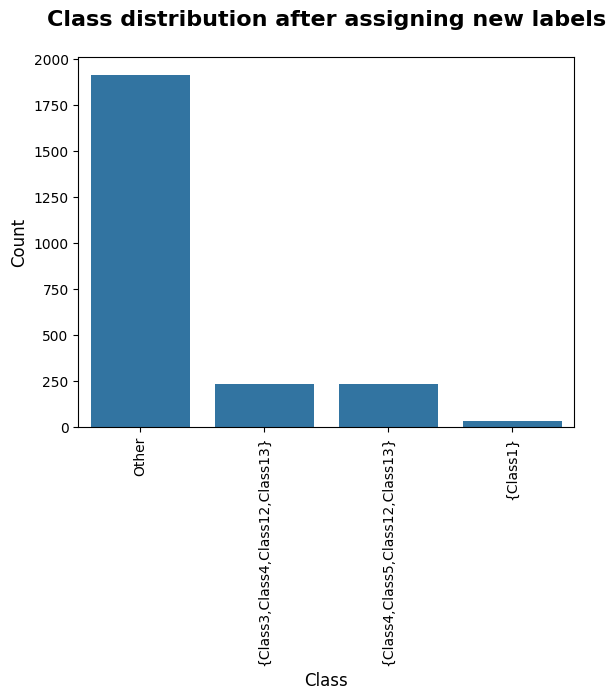

In [13]:
plt.plot(figsize=(10,6))
sns.countplot(data=y, x='Label', order=y['Label'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Class distribution after assigning new labels\n", **{"fontsize":16, "fontweight":"bold"})
plt.ylabel("Count", **{"fontsize":12})
plt.xlabel("Class", **{"fontsize":12})
plt.show()

## 4. Scaling

In [14]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

Distance-based dimensionality reduction techniques like **t-SNE** and **Isomap** rely on computing pairwise distances between data points.  

Without proper scaling:

1. **Feature Dominance**: Features with larger numerical ranges dominate distance calculations, causing smaller-scale features to be effectively ignored.
2. **Distance Distortion**: Euclidean distances become biased toward high-variance features, misrepresenting true similarity structure.
3. **Algorithm Sensitivity**: Both t-SNE and Isomap use neighborhood graphs; unscaled features lead to incorrect neighbor identification.
4. **Manifold Misrepresentation**: The underlying manifold structure can be obscured by scale differences.

**Standardization (Z-score normalization)** transforms each feature to have mean 0 and standard deviation 1, ensuring all features contribute equally to distance computations.

In [15]:
print("Scaled matrix shape:", X_scaled.shape)
print("Mean (approx):", np.mean(X_scaled).round(3))
print("Std (approx):", np.std(X_scaled).round(3))

Scaled matrix shape: (2417, 103)
Mean (approx): 0.0
Std (approx): 1.0


# B. t-SNE and Veracity Inspection

## 1. t-SNE Implementation

In [16]:
perplexities = [5, 30, 50, 100, 150, 200, 250, 300, 400, 500, 650, 700]
tsne_results = {}

for perplexity in perplexities:
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, max_iter=1000, n_jobs=4)
    X_tsne = tsne.fit_transform(X_scaled)
    tsne_results[perplexity] = (X_tsne, tsne)

## 2. Visualization

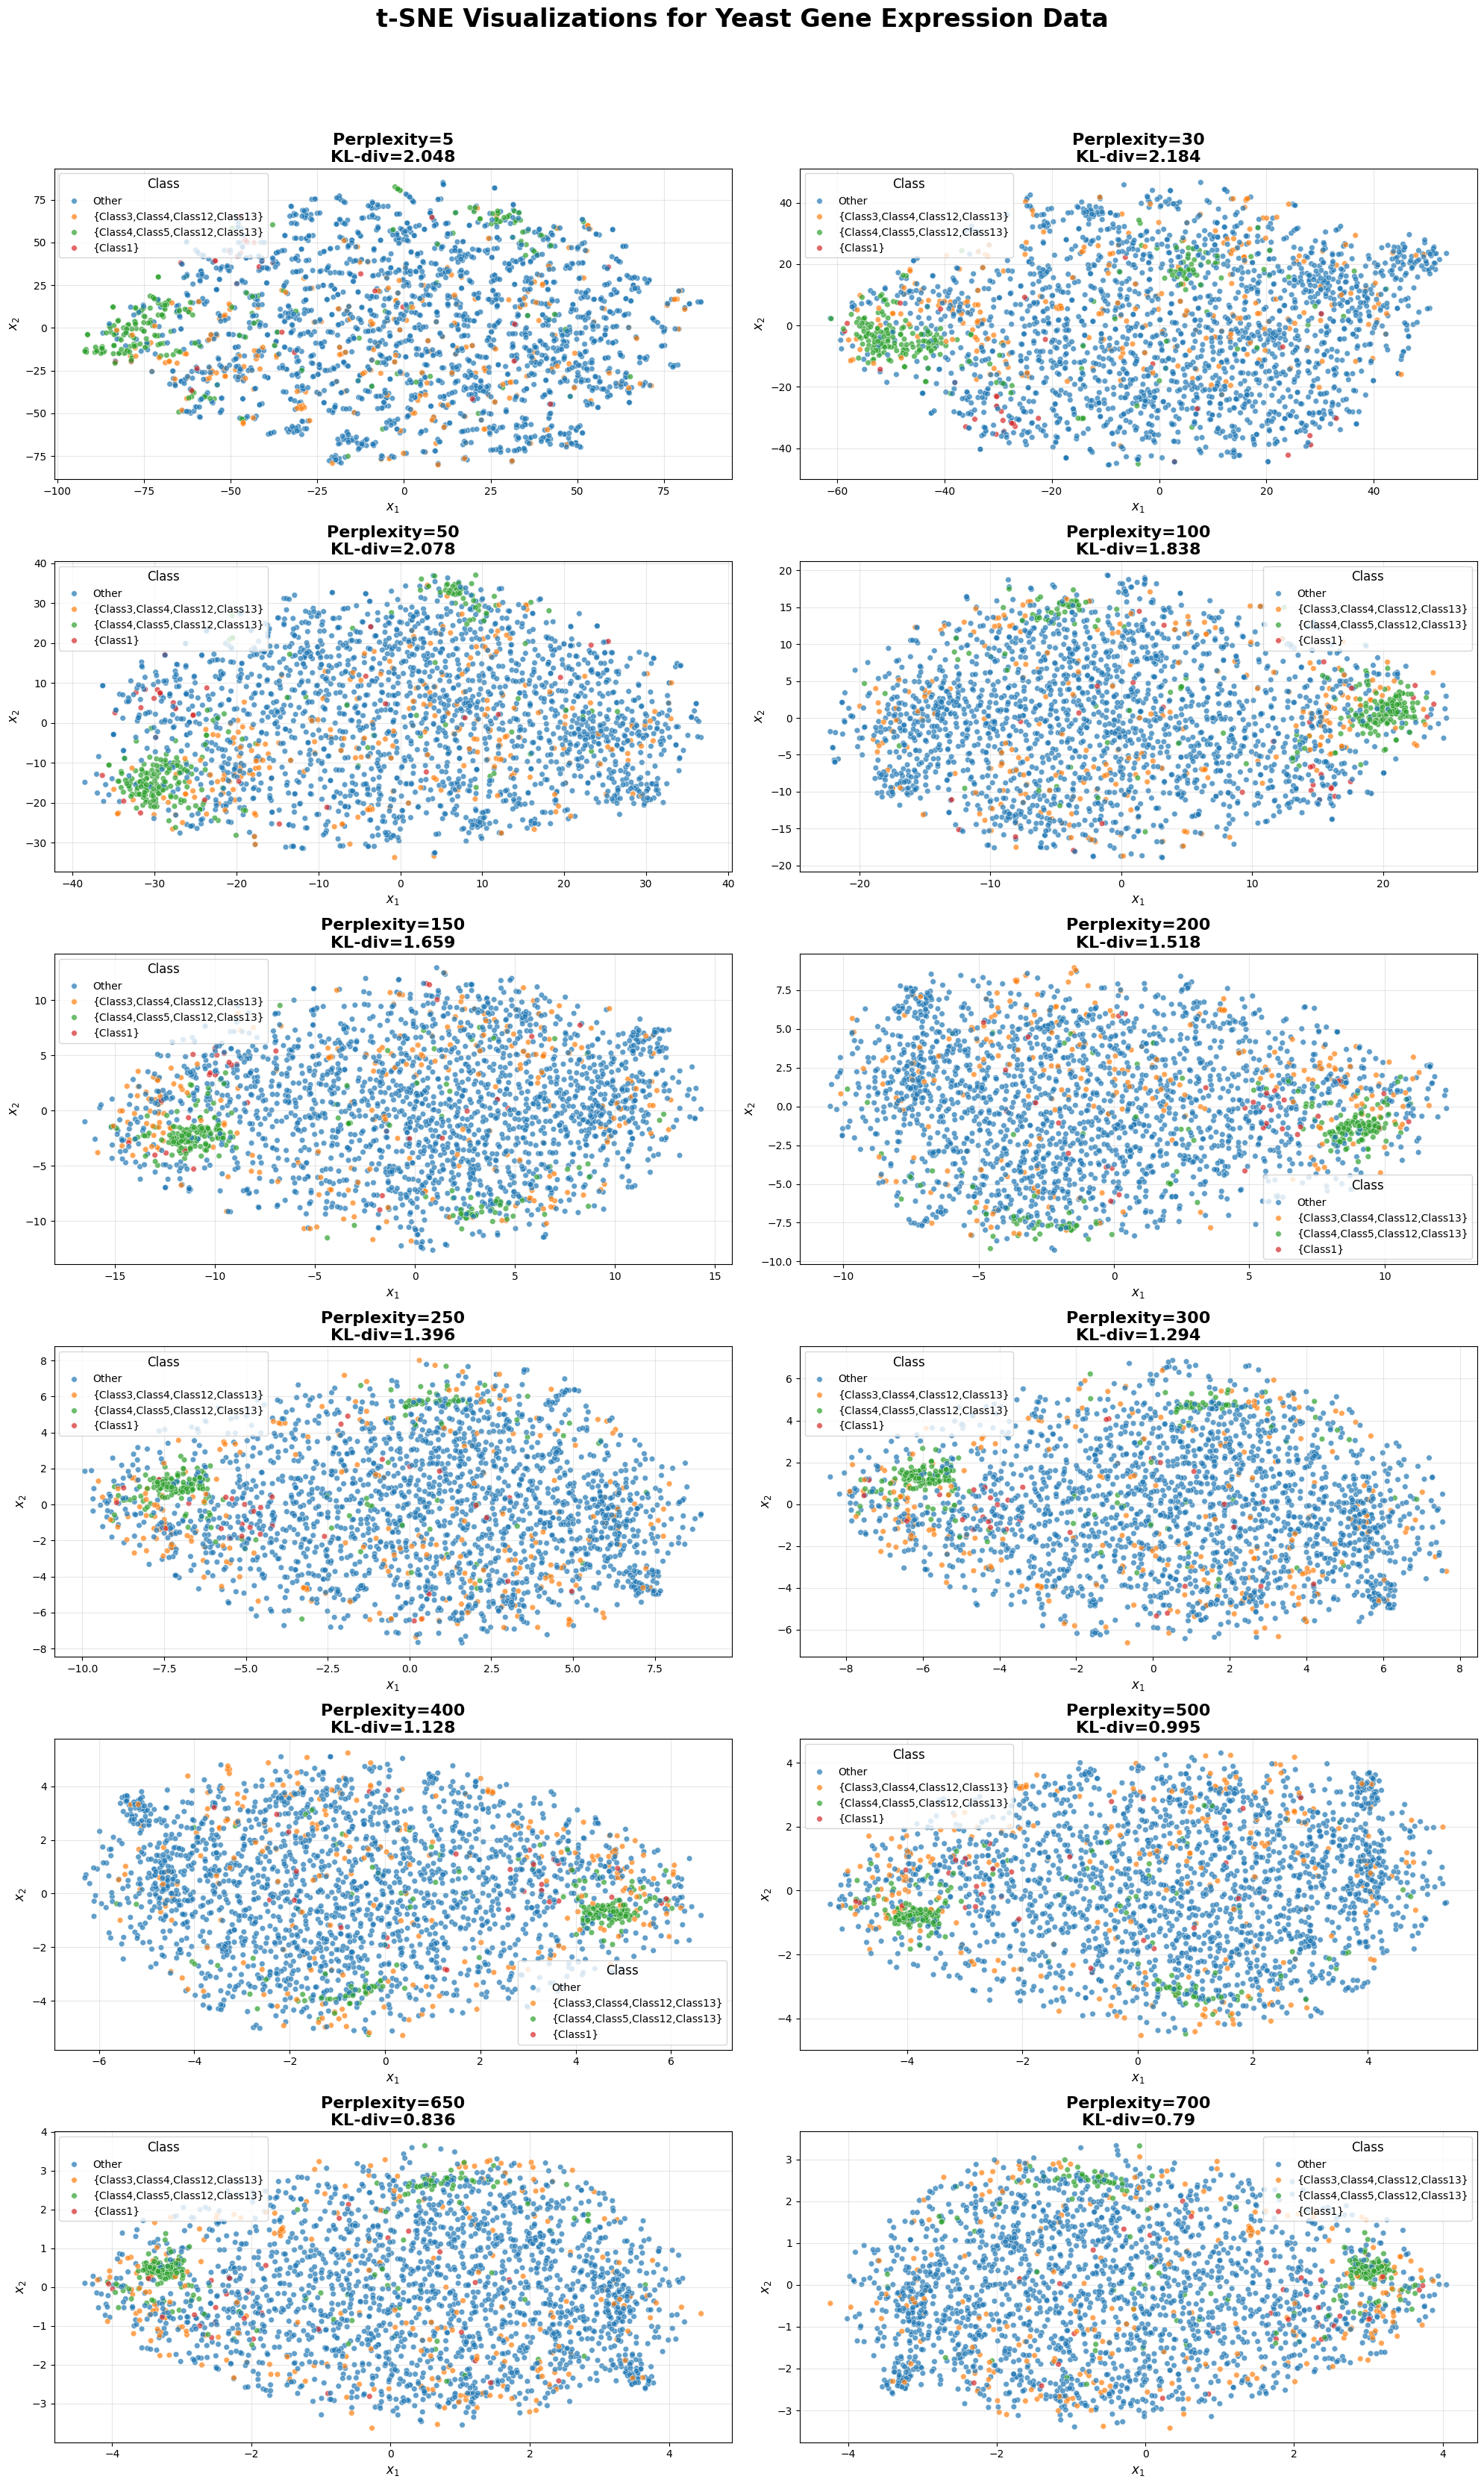

In [17]:
fig, axes = plt.subplots(len(perplexities)//2, 2, figsize=(20, 35),
                        #  sharex=True, sharey=True
                         )
axes = axes.flatten()
for i, perp in enumerate(perplexities):
    X_tsne, tsne = tsne_results[perp]
    scatter = sns.scatterplot(
        x=X_tsne[:,0], 
        y=X_tsne[:,1], 
        hue=y['Label'], 
        palette="tab10",
        s=30, ax=axes[i],
        legend='auto',
        alpha=0.7,
    )
    axes[i].set_title(f"Perplexity={perp}\nKL-div={round(tsne.kl_divergence_, 3)}", **{"fontsize":16, "fontweight":"bold"})
    axes[i].set_xlabel("$x_1$", **{"fontsize":12,})
    axes[i].set_ylabel("$x_2$", **{"fontsize":12,})
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(loc='best', fontsize=10, title='Class', title_fontsize=12)
    # axes[i].legend_.remove()
plt.suptitle("t-SNE Visualizations for Yeast Gene Expression Data", **{"fontsize":24, "fontweight":"bold"})
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

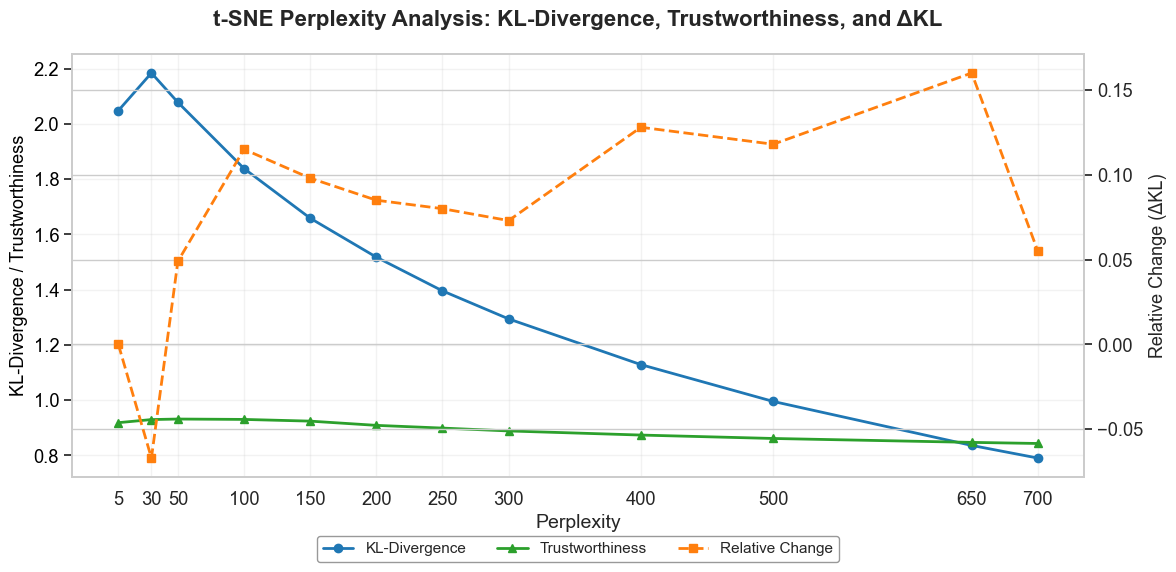

In [18]:
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.2)

kl_divs = []
trusts = []
for p in perplexities:
    X_tsne, tsne = tsne_results[p]
    kl_divs.append(tsne.kl_divergence_)
    trusts.append(trustworthiness(X_scaled, X_tsne, n_neighbors=10))

# Compute relative change in KL-divergence
rel_change = [0] + [round((kl_divs[i-1] - kl_divs[i]) / kl_divs[i-1], 3) for i in range(1, len(kl_divs))]

fig, ax1 = plt.subplots(figsize=(12, 6))

color1 = sns.color_palette("tab10")[0]   # blue
color2 = sns.color_palette("tab10")[1]   # orange
color3 = sns.color_palette("tab10")[2]   # green

line1 = ax1.plot(perplexities, kl_divs, marker='o', color=color1, linewidth=2, label='KL-Divergence')
line2 = ax1.plot(perplexities, trusts, marker='^', color=color3, linewidth=2, label='Trustworthiness')
ax1.set_xlabel('Perplexity', fontsize=14)
ax1.set_ylabel('KL-Divergence / Trustworthiness', fontsize=13, color='black')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()
line3 = ax2.plot(perplexities, rel_change, marker='s', color=color2, linewidth=2, linestyle='--', label='Relative Change')
ax2.set_ylabel('Relative Change (ΔKL)', fontsize=13,)
ax2.tick_params(axis='y',)

lines = line1 + line2 + line3
labels = [line.get_label() for line in lines]

legend = ax1.legend(
    lines,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.12),
    ncol=3,
    frameon=True,
    fontsize=11,
)

legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('gray')

plt.title('t-SNE Perplexity Analysis: KL-Divergence, Trustworthiness, and ΔKL',
          fontsize=16, fontweight='bold', pad=20)
ax1.grid(alpha=0.25)
plt.xticks(perplexities)
plt.tight_layout()
plt.show()

Perplexity ≈ 100 provides the best compromise between minimizing global distortion (KL ≈ 1.84) and maintaining strong local neighborhood faithfulness (trust ≈ 0.93). Values beyond this begin to smooth out local cluster structure without significant KL gain.

In [19]:
X_tsne_final, tsne_final = tsne_results[100]

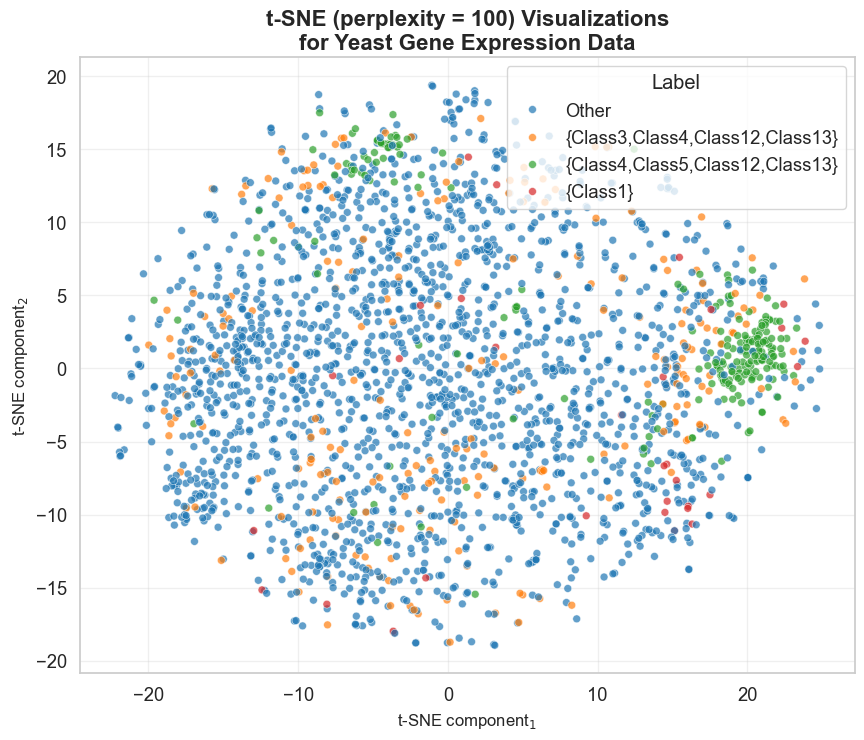

In [29]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    x=X_tsne_final[:,0], y=X_tsne_final[:,1],
    hue=y['Label'],
    alpha=0.7, s=32,
    palette="tab10",
)
plt.xlabel("t-SNE component$_1$", **{"fontsize":12})
plt.ylabel("t-SNE component$_2$", **{"fontsize":12})
plt.title("t-SNE (perplexity = 100) Visualizations\nfor Yeast Gene Expression Data", **{"fontsize":16, "fontweight":"bold"})
plt.grid(True, alpha=0.3)
plt.show()

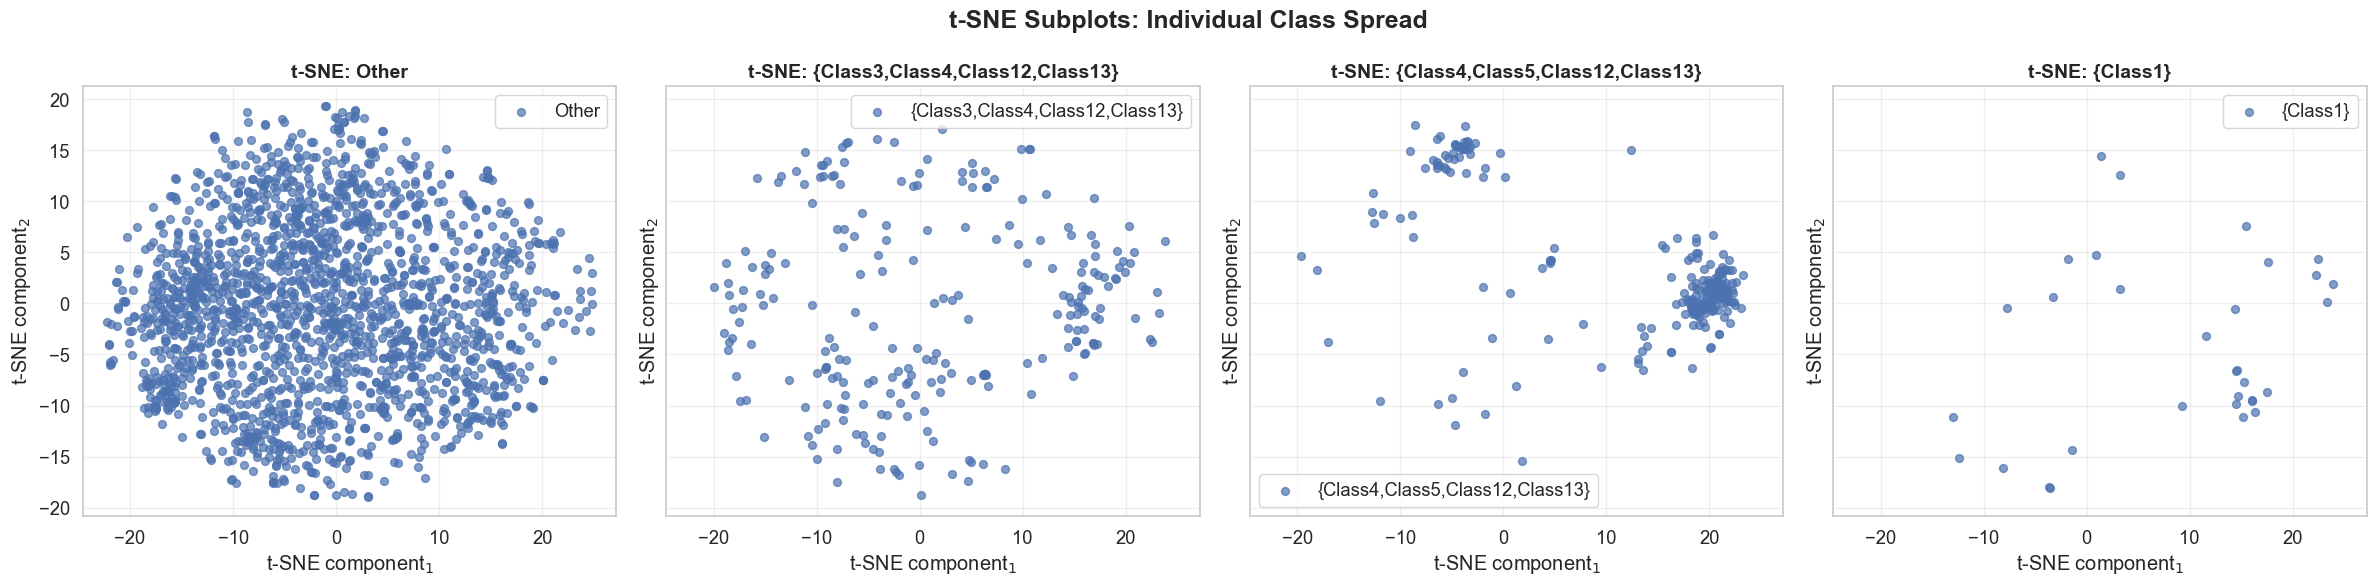

In [41]:
classes = y['Label'].unique()
fig, axes = plt.subplots(1, len(classes), figsize=(6 * len(classes), 6), sharex=True, sharey=True)

for i, cls in enumerate(classes):
    mask = y['Label'] == cls
    axes[i].scatter(X_tsne_final[mask, 0], X_tsne_final[mask, 1], s=32, alpha=0.7, label=cls)
    axes[i].set_title(f"t-SNE: {cls}", fontsize=14, fontweight="bold")
    axes[i].set_xlabel("t-SNE component$_1$")
    axes[i].set_ylabel("t-SNE component$_2$")
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

plt.suptitle("t-SNE Subplots: Individual Class Spread", fontsize=18, fontweight="bold")
plt.tight_layout()
plt.show()

This figure shows t-SNE projections of individual class spreads for yeast gene expression data, with each subplot focused on a different class or class group.

- The "Other" class (far left) covers the t-SNE space broadly and densely, showing that these samples are highly heterogeneous and intermixed, with little sign of focused clustering.
- The grouped classes (\{Class3, Class4, Class12, Class13\}) display moderate scatter, lacking a single cohesive cluster, though substructures might be present.
- The group \{Class4, Class5, Class12, Class13\} forms two clear, tight clusters, suggesting these genes have strong internal similarity, but also a few outliers.
- Class1 is smaller and moderately scattered, with no tight grouping.

**Classification implications:**  
The broad spread and overlap in most classes (especially "Other") mean that clear boundaries between classes are rare, making classification difficult for linear and even many non-linear classifiers. Only the subset forming tight clusters would be easier to separate. In practice, significant class overlap requires flexible, possibly non-linear models, and highlights the risk of misclassification in regions with diffuse or scattered examples.


## 3. Veracity Inspection

+ **Noisy/Ambiguous Labels:** Points where one color is deeply embedded within a cluster of a different color.
+ **Outliers:** Isolated points or tiny, distant clusters. These unusual expression patterns might represent something.
+ **Hard-to-Learn Samples:** Areas where functional category colors are thoroughly mixed. A a simple classifier would likely struggle in these regions.

In [20]:
def find_noisy_labels(X_embedded, y_labels, k=10, threshold=0.3):
    """
    Identify points surrounded by different classes in the embedding.
    Returns indices and ratios for noisy points.
    """
    nbrs = NearestNeighbors(n_neighbors=k+1)
    nbrs.fit(X_embedded)
    _, indices = nbrs.kneighbors(X_embedded)
    
    noisy_points = []
    for i in range(len(y_labels)):
        neighbors = indices[i, 1:]  # Exclude self
        neighbor_labels = y_labels[neighbors]
        own_label = y_labels[i]
        same_label_ratio = np.sum(neighbor_labels == own_label) / k
        if same_label_ratio < threshold:
            noisy_points.append((i, same_label_ratio))
    return noisy_points

y_viz = y['Label'].values
n_samples = X_tsne_final.shape[0]
noisy_points = find_noisy_labels(X_tsne_final, y_viz, k=10, threshold=0.3)
print(f"Identified {len(noisy_points)} potentially noisy/ambiguous samples ({100*len(noisy_points)/n_samples:.2f}%)")

Identified 277 potentially noisy/ambiguous samples (11.46%)


These points are embedded within clusters of different functional categories, suggesting potential label misclassification or genes with ambiguous functions.

In [21]:
def find_outliers(X_embedded):
    """
    Identify outliers in the embedding using Local Outlier Factor.
    Returns indices of outlier points.
    """
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
    outlier_labels = lof.fit_predict(X_embedded)
    outliers = np.where(outlier_labels == -1)[0]
    return outliers

outliers = find_outliers(X_tsne_final)
print(f"Identified {len(outliers)} outlier samples ({100*len(outliers)/n_samples:.2f}%)")

Identified 121 outlier samples (5.01%)


These represent experiments with highly unusual gene expression patterns.  
Biological interpretation: Could be experimental errors, rare biological conditions, or genes with unique regulatory mechanisms not captured by standard functional categories.

In [23]:
def find_hard_to_learn(X_embedded, y_labels, k=10, threshold=0.5):
    """
    Identify points that are hard to learn based on neighbor class distribution.
    Returns indices and ratios for hard-to-learn points.
    `threshold`: If the fraction of same-label neighbors is below this threshold,
        the point is considered 'hard to learn'.
    """
    # Fit k-NN on the embedded space
    nbrs = NearestNeighbors(n_neighbors=k+1)
    nbrs.fit(X_embedded)
    _, indices = nbrs.kneighbors(X_embedded)
    
    same_label_ratios = []
    hard_indices = []

    for i in range(len(y_labels)):
        neighbors = indices[i, 1:]  # exclude the point itself
        neighbor_labels = y_labels[neighbors]
        own_label = y_labels[i]
        
        # Fraction of neighbors with the same label
        same_label_ratio = np.sum(neighbor_labels == own_label) / k
        same_label_ratios.append(same_label_ratio)
        
        # Mark as hard-to-learn if local consistency is low
        if same_label_ratio < threshold:
            hard_indices.append(i)
    
    return hard_indices, np.array(same_label_ratios)


#### Step-by-step Breakdown

1. **Local Neighborhood Identification:**
   - For each point in the embedding space `X_embedded`, we find its `k` nearest neighbors using Euclidean distance.
   - This local region represents how the model "perceives" the data’s structure.

2. **Label Agreement Computation:**
   - For each point, we calculate how many of its neighbors share the same class label.
   - The **same-label ratio** is given by:  
      $
      r_i = \frac{\text{\#(neighbors with same label as i)}}{k}
      $


3. **Thresholding:**
   - If  $r_i < \text{threshold}$ , the point is labeled **hard-to-learn**.
   - Intuitively, this means that the point lies near a **decision boundary** or within a **class overlap region**, where local neighborhoods are mixed with multiple labels.

4. **Output:**
   - `hard_indices`: indices of potentially confusing or ambiguous samples.
   - `same_label_ratios`: array of how “confident” or “pure” each sample’s local neighborhood is.

---

- **Low same-label ratio → locally confusing region → hard-to-learn.**
- These regions often correspond to:
  - Class boundaries  
  - Outliers  
  - Label noise  
  - Overlapping feature distributions  



In [24]:
y_viz = y['Label'].values
hard_indices, same_label_ratios = find_hard_to_learn(X_tsne_final, y_viz, k=10, threshold=0.5)
print(f"Identified {len(hard_indices)} hard-to-learn samples ({100*len(hard_indices)/n_samples:.2f}%)")

Identified 395 hard-to-learn samples (16.34%)


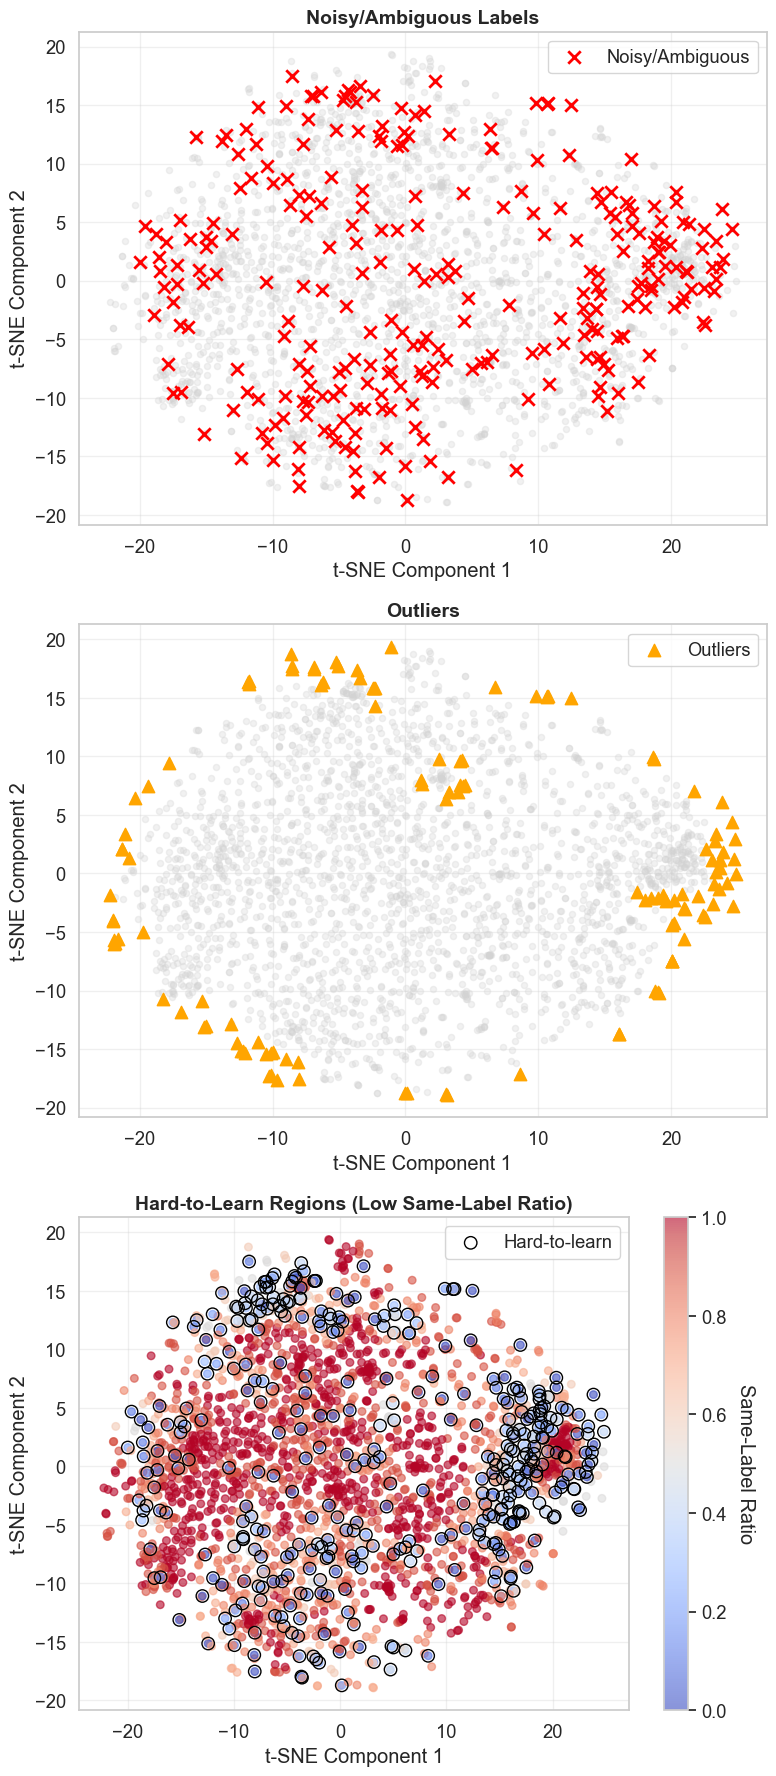

In [26]:
fig, axes = plt.subplots(3, 1, figsize=(8, 18))  # 3 rows, 1 column

# Plot 1: Noisy/Ambiguous Labels
ax1 = axes[0]
ax1.scatter(X_tsne_final[:, 0], X_tsne_final[:, 1], c='lightgray', alpha=0.3, s=20)
noisy_indices = [idx for idx, _ in noisy_points]
ax1.scatter(X_tsne_final[noisy_indices, 0], X_tsne_final[noisy_indices, 1],
            c='red', s=80, marker='x', linewidth=2, label='Noisy/Ambiguous')
ax1.set_title('Noisy/Ambiguous Labels', fontsize=14, fontweight='bold')
ax1.set_xlabel('t-SNE Component 1')
ax1.set_ylabel('t-SNE Component 2')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Outliers
ax2 = axes[1]
ax2.scatter(X_tsne_final[:, 0], X_tsne_final[:, 1], c='lightgray', alpha=0.3, s=20)
ax2.scatter(X_tsne_final[outliers, 0], X_tsne_final[outliers, 1],
            c='orange', s=80, marker='^', label='Outliers')
ax2.set_title('Outliers', fontsize=14, fontweight='bold')
ax2.set_xlabel('t-SNE Component 1')
ax2.set_ylabel('t-SNE Component 2')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Hard-to-learn samples (low same-label ratio)
ax3 = axes[2]
scatter = ax3.scatter(X_tsne_final[:, 0], X_tsne_final[:, 1],
                      c=same_label_ratios, cmap='coolwarm', s=30, alpha=0.6)
ax3.scatter(X_tsne_final[hard_indices, 0], X_tsne_final[hard_indices, 1],
            edgecolor='black', facecolor='none', s=80, marker='o', label='Hard-to-learn')
ax3.set_title('Hard-to-Learn Regions (Low Same-Label Ratio)', fontsize=14, fontweight='bold')
ax3.set_xlabel('t-SNE Component 1')
ax3.set_ylabel('t-SNE Component 2')
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Same-Label Ratio', rotation=270, labelpad=20)
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 1. Noisy/Ambiguous Labels

In the t-SNE plot, we observe instances where points of one color (functional category) are deeply embedded within clusters dominated by different colors. These represent:

- **Genes with overlapping functions**: Some genes legitimately belong to multiple categories, but the dominant neighborhood suggests potential misclassification.
- **Annotation errors**: Historical functional annotations may be incomplete or incorrect.
- **Biological ambiguity**: Genes at functional boundaries whose roles are genuinely unclear.

These noisy labels pose challenges for classification models as they create inconsistent training signals.

#### 2. Outliers

The analysis identified isolated points and small, distant clusters in the t-SNE space. These outliers likely represent:

- **Experimental errors**: Technical issues during gene expression measurement.
- **Rare biological conditions**: Genes with unique expression patterns under specific conditions.
- **Novel regulatory mechanisms**: Genes not well-represented by the 14 standard functional categories.

**Biological hypothesis**: These unusual expression patterns could indicate genes involved in stress responses or condition-specific pathways that don't fit standard functional classifications.

#### 3. Hard-to-Learn Samples

Regions with high label entropy/ low same-label ratio show thorough mixing of multiple functional categories. Classification challenges include:

- **Complex decision boundaries**: Linear classifiers cannot separate mixed regions effectively.
- **High model uncertainty**: Even sophisticated models will have low-confidence predictions.
- **Training instability**: Mixed regions create conflicting gradients during model training.

**Why classifiers struggle**: Simple classifiers assume relatively smooth decision boundaries, but mixed regions require highly non-linear separations that are difficult to learn reliably without overfitting.


# C. Isomap and Manifold Learning

## 1. Isomap Implementation

In [27]:
isomap = Isomap(n_components=2, n_neighbors=10)
X_isomap = isomap.fit_transform(X_scaled)

reconstruction_error = isomap.reconstruction_error()
print(f"Isomap reconstruction error: {reconstruction_error:.4f}")

Isomap reconstruction error: 189.9374


<!-- **Isomap (Isometric Mapping)**:
- **Objective**: Preserve global geodesic distances along the manifold.
- **Method**: Constructs a neighborhood graph, computes shortest paths (geodesic distances), then applies MDS (Multidimensional Scaling).
- **Structure preservation**: Emphasizes global structure - maintains relative distances across the entire dataset.
- **Use case**: Best for unfolding a single, continuous low-dimensional manifold.

**t-SNE (t-Distributed Stochastic Neighbor Embedding)**:
- **Objective**: Preserve local neighborhood structure.
- **Method**: Converts distances to probability distributions, minimizes KL divergence between high and low dimensions.
- **Structure preservation**: Emphasizes local structure - focuses on keeping nearby points together.
- **Use case**: Excellent for revealing clusters and local patterns, handles multiple manifolds.

**Key Distinction**: Isomap is a global method that attempts to preserve the overall geometry of the data manifold, while t-SNE is a local method that prioritizes maintaining neighborhood relationships. This makes Isomap better for understanding overall data topology, while t-SNE excels at revealing cluster structure. -->

**Isomap (Isometric Mapping)**

**Objective:** Preserve **global geodesic distances** along the data manifold - i.e., capture the true curved distances that follow the intrinsic structure of the data, rather than straight-line (Euclidean) distances.

**How It Works:**

1. **Neighborhood Graph Construction:** Each data point is connected to its nearest neighbors (based on Euclidean distance).  
2. **Geodesic Distance Estimation:** Replace Euclidean distances with **shortest-path distances** on this graph (approximating geodesic distances along the manifold).  
3. **Dimensionality Reduction via MDS:** Apply **Multidimensional Scaling (MDS)** on the geodesic distance matrix to find a low-dimensional embedding that preserves those distances as faithfully as possible.

**Structure Preservation:**
- **Global structure preservation:** Maintains relationships between distant points and overall manifold geometry.  
- Unfolds the manifold while preserving its intrinsic shape and large-scale geometry.  
- Can fail if the manifold has disconnected regions or sharp folds.

**Use case**: Best for unfolding a single, continuous low-dimensional manifold.
<!-- **Best Use Cases:**
- When data lies on a **single, smooth, continuous manifold**.  
- When the goal is to visualize or understand **overall topology** (e.g., “unfolding” a Swiss roll or curved surface). -->
---

**t-SNE (t-Distributed Stochastic Neighbor Embedding)**

**Objective:** Preserve **local neighborhood structure** - ensuring that points that are close in high-dimensional space remain close in the low-dimensional embedding.

**How It Works:**

1. **Convert Distances to Probabilities:** Compute pairwise similarities in high-dimensional space using Gaussian kernels. Compute pairwise similarities in low-dimensional space using a Student-t distribution (with heavier tails).  
2. **Optimize via KL Divergence Minimization:** Minimize the **Kullback–Leibler (KL) divergence** between the two distributions to align local neighborhoods.

**Structure Preservation:**
- **Local structure preservation:** Focuses on retaining local clusters and neighborhood relationships.  
- Points in the same cluster stay close, while distances between clusters may be exaggerated or compressed.  
- Global distances are **not meaningful** - clusters’ relative placement can vary between runs.

<!-- **Best Use Cases:**
- When the goal is to **visualize local groupings or cluster structures**.  
- Ideal for **high-dimensional datasets with multiple manifolds or clusters**, such as word embeddings or gene expression data. -->
**Use case**: Excellent for revealing clusters and local patterns, handles multiple manifolds.

---
**Summarization**

| Aspect | **Isomap** | **t-SNE** |
|:--|:--|:--|
| **Focus** | Global geometry | Local neighborhoods |
| **Distance Basis** | Geodesic distances | Probabilistic similarities |
| **Optimization Goal** | Preserve manifold’s overall structure | Preserve local density relationships |
| **Output Interpretation** | Captures true manifold topology | Captures relative local grouping |
| **Best For** | Single continuous manifold | Multiple clusters or disjoint manifolds |
| **Global vs Local** | Global method | Local method |
| **Sensitivity** | Sensitive to disconnected graphs | Sensitive to perplexity and learning rate |


## 2. Visualization

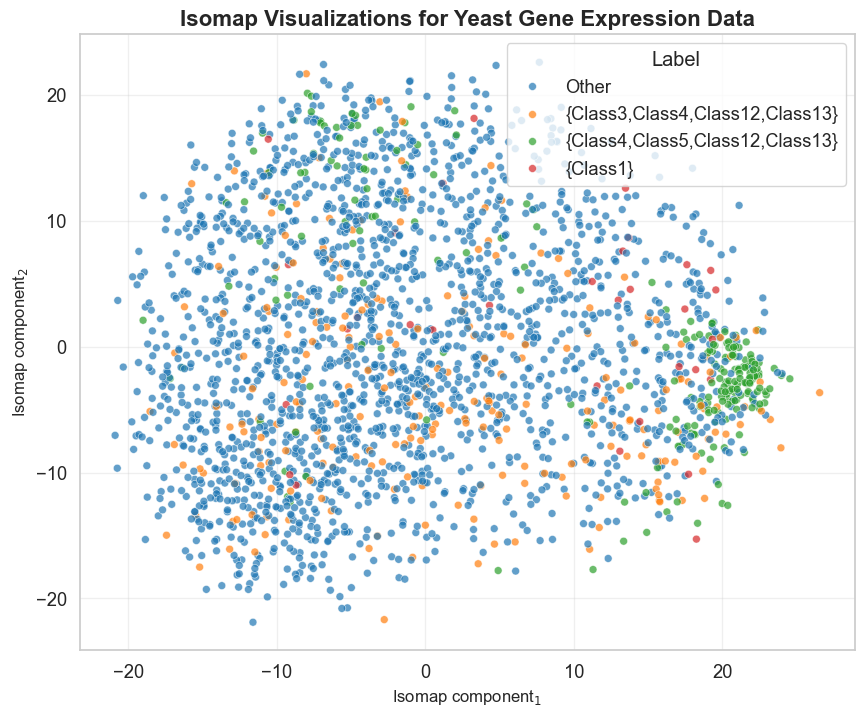

In [30]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    x=X_isomap[:,0], y=X_isomap[:,1],
    hue=y['Label'],
    alpha=0.7, s=32,
    palette="tab10",
)
plt.xlabel("Isomap component$_1$", **{"fontsize":12})
plt.ylabel("Isomap component$_2$", **{"fontsize":12})
plt.title("Isomap Visualizations for Yeast Gene Expression Data", **{"fontsize":16, "fontweight":"bold"})
plt.grid(True, alpha=0.3)
plt.show()

While most points (blue, labeled "Other") are scattered broadly without clear separation, some classes like `{Class4, Class5, Class12, Class13}` (green) form a denser cluster toward the right side. Other classes (orange, red) appear more dispersed and overlapping, indicating limited class separability in this low-dimensional embedding.

## 3. Comparison and Curvature

### Compare Isomap visualization to t-SNE visualization

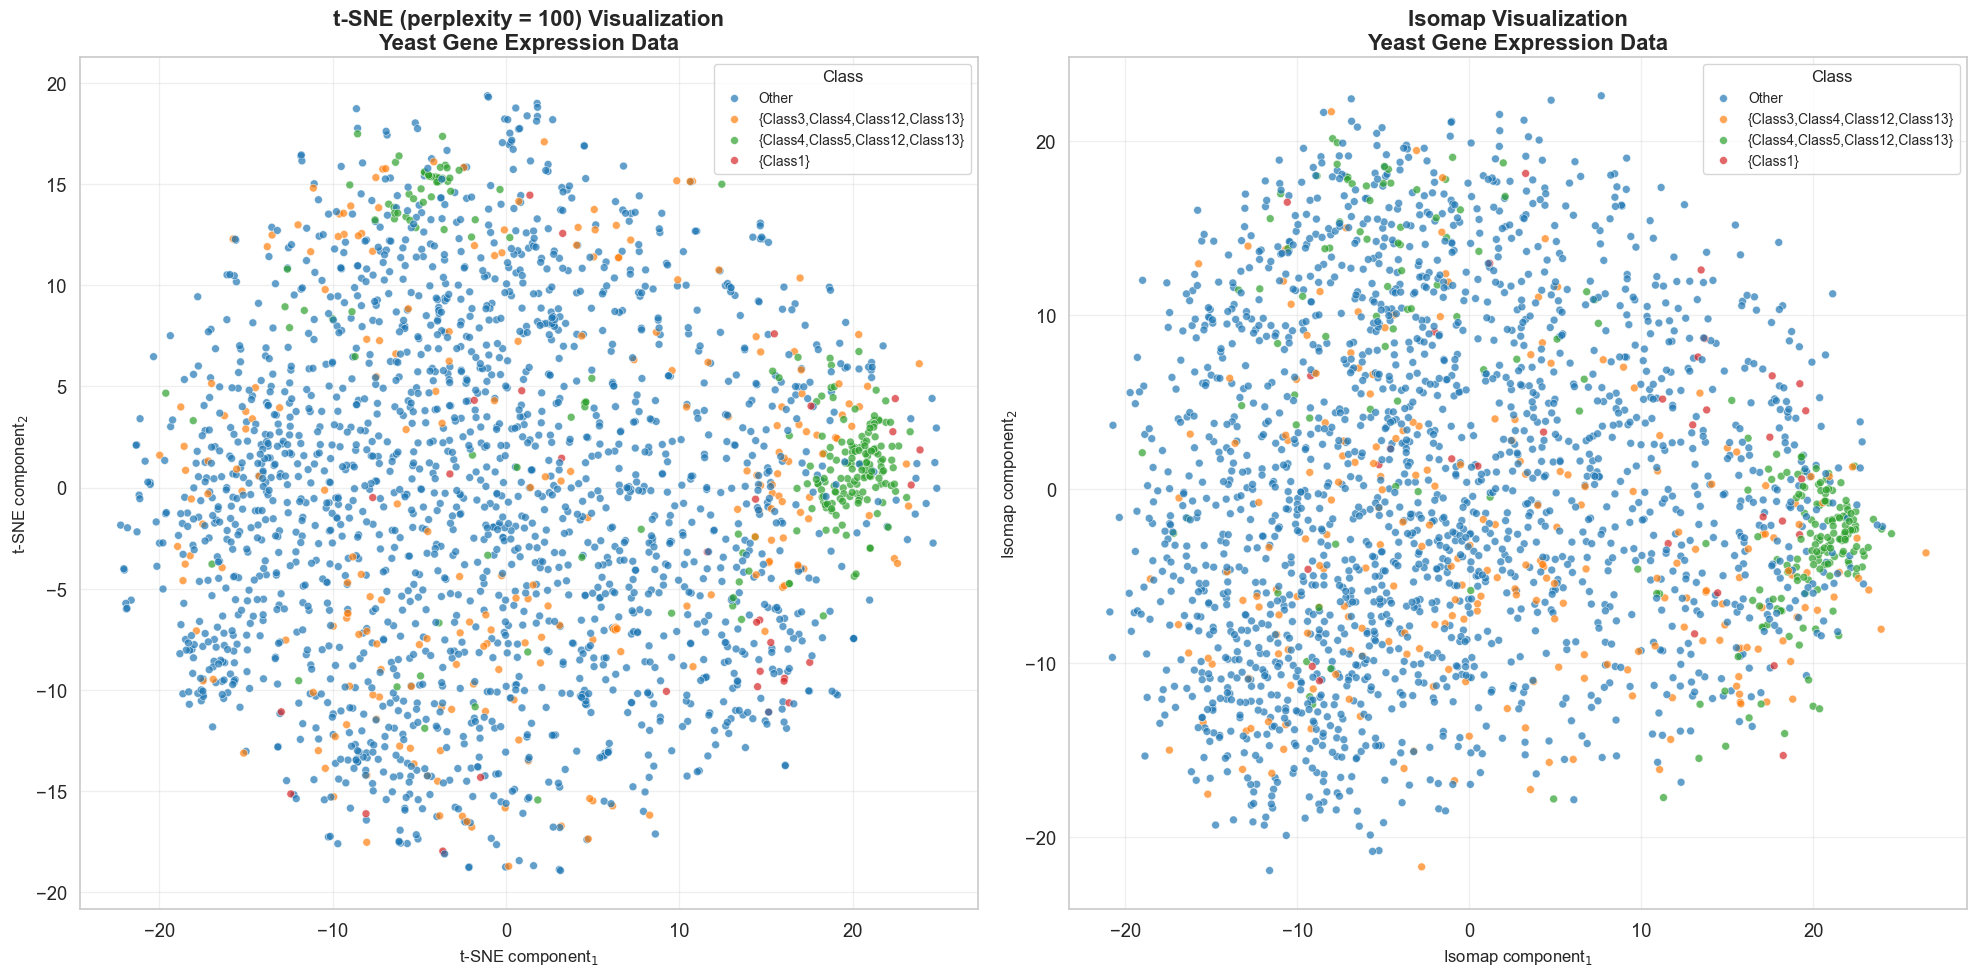

In [33]:
fig, axes = plt.subplots(1,2, figsize=(20, 10))  # 1 row, 2 columns

# t-SNE plot
sns.scatterplot(
    x=X_tsne_final[:, 0], y=X_tsne_final[:, 1],
    hue=y['Label'],
    alpha=0.7, s=32,
    palette="tab10",
    ax=axes[0]
)
axes[0].set_xlabel("t-SNE component$_1$", fontsize=12)
axes[0].set_ylabel("t-SNE component$_2$", fontsize=12)
axes[0].set_title("t-SNE (perplexity = 100) Visualization\nYeast Gene Expression Data", fontsize=16, fontweight="bold")
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='best', fontsize=10, title='Class', title_fontsize=12)

# Isomap plot
sns.scatterplot(
    x=X_isomap[:, 0], y=X_isomap[:, 1],
    hue=y['Label'],
    alpha=0.7, s=32,
    palette="tab10",
    ax=axes[1]
)
axes[1].set_xlabel("Isomap component$_1$", fontsize=12)
axes[1].set_ylabel("Isomap component$_2$", fontsize=12)
axes[1].set_title("Isomap Visualization\nYeast Gene Expression Data", fontsize=16, fontweight="bold")
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='best', fontsize=10, title='Class', title_fontsize=12)

plt.tight_layout()
plt.show()

**Comparison of t-SNE vs Isomap Visualizations:**

* **t-SNE** excels at revealing **local structure** and cluster separation. In the left plot, you can see that the main classes (green, orange, red) are more distinctly grouped, and local neighborhoods are preserved. However, the overall spatial arrangement of clusters is not meaningful—distances between clusters and their global layout can vary between runs.

* **Isomap** (right plot) is designed to preserve **global structure**—the relative positions and distances between all points reflect the underlying manifold geometry. Here, the green cluster is still visible, but the overall spread of points is more continuous, and distant points remain distant. Isomap maintains the large-scale topology of the data better, even if local clusters are less sharply separated.

Isomap is **better at revealing the global structure** of the gene expression data, as it preserves the manifold’s overall geometry and relationships between distant points. t-SNE is superior for visualizing local clusters and class separation, but its global arrangement is not reliable. We can use Isomap for understanding overall data topology; else we use t-SNE for exploring local groupings and cluster purity.


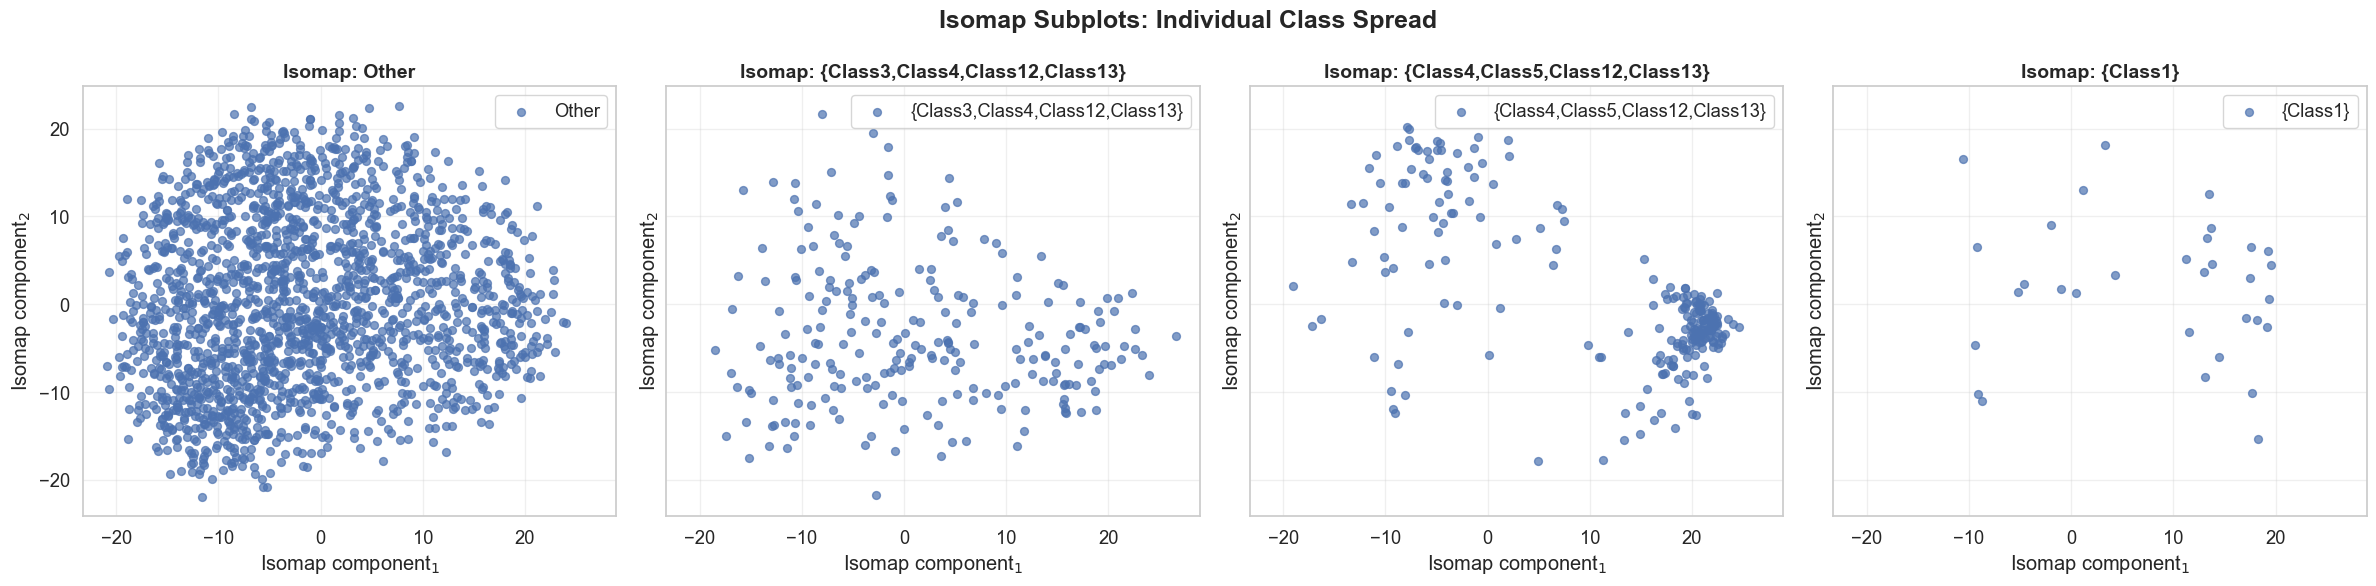

In [43]:
classes = y['Label'].unique()
fig, axes = plt.subplots(1, len(classes), figsize=(6 * len(classes), 6), sharex=True, sharey=True)

for i, cls in enumerate(classes):
    mask = y['Label'] == cls
    axes[i].scatter(X_isomap[mask, 0], X_isomap[mask, 1], s=32, alpha=0.7, label=cls)
    axes[i].set_title(f"Isomap: {cls}", fontsize=14, fontweight="bold")
    axes[i].set_xlabel("Isomap component$_1$")
    axes[i].set_ylabel("Isomap component$_2$")
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

plt.suptitle("Isomap Subplots: Individual Class Spread", fontsize=18, fontweight="bold")
plt.tight_layout()
plt.show()

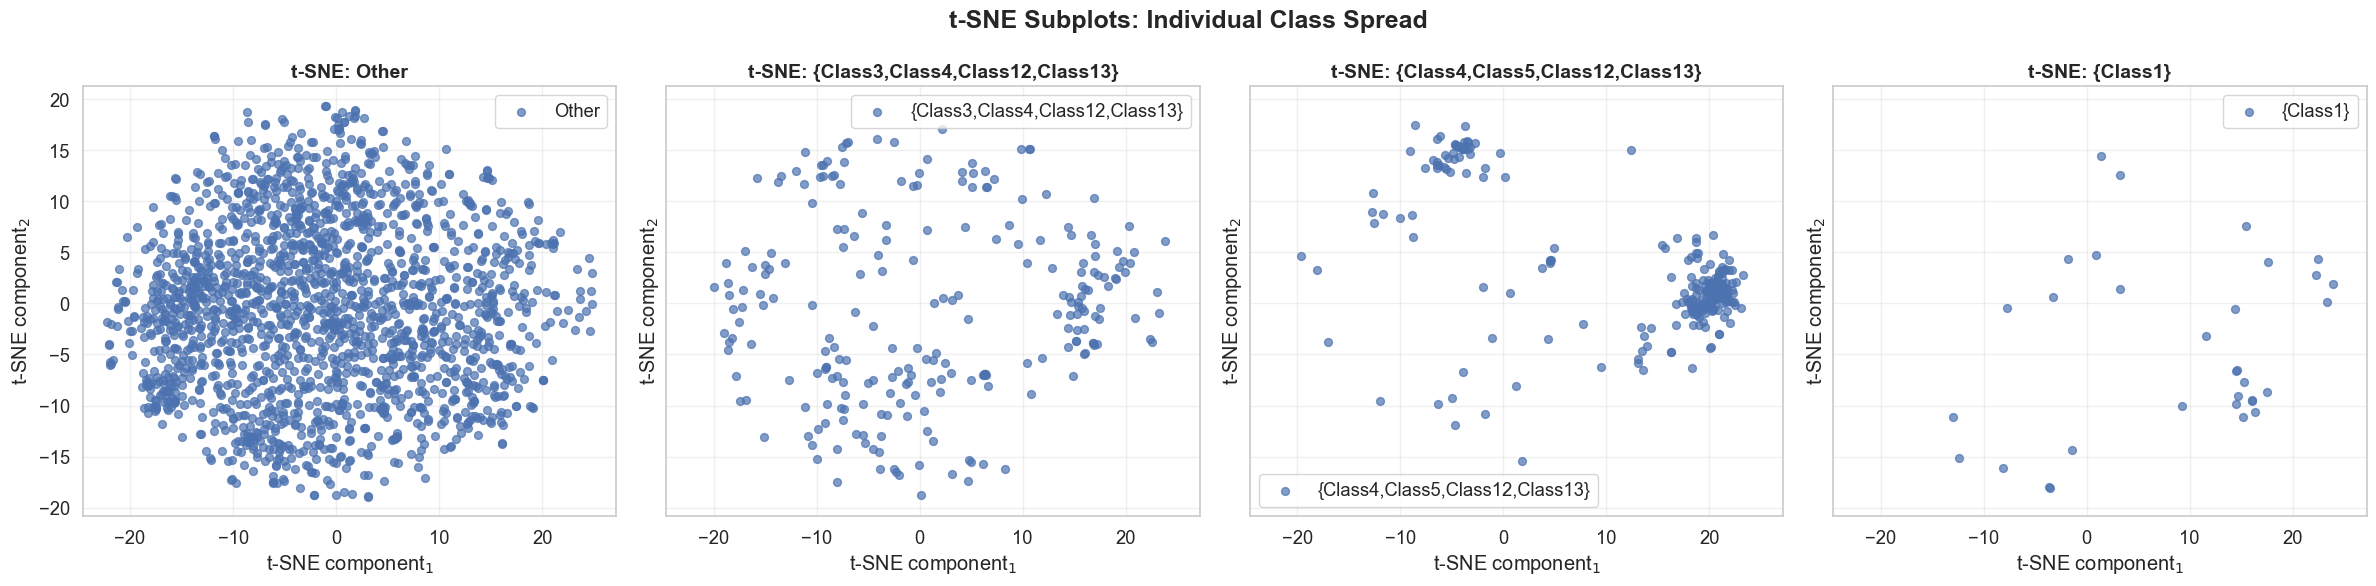

The Isomap subplots show class-specific spreads similar to the t-SNE subplots but with key differences:

- Like t-SNE, Isomap’s "Other" class is widely scattered, indicating heterogeneity.
- Groups like \{Class3, Class4, Class12, Class13\} still show scattered points, and \{Class4, Class5, Class12, Class13\} exhibit a tighter cluster but with more pronounced continuous spread around it, reflecting Isomap’s preservation of global manifold geometry.
- Class1 remains scattered but without strong local clustering.

**How Isomap differs from t-SNE here:**

- Isomap preserves **global structure** by approximating geodesic distances on the data manifold, revealing a more continuous, smooth distribution of points across classes.
- t-SNE tends to emphasize **local neighborhoods**, creating tighter, more discrete clusters but less reliable global arrangement.
- In classification terms, Isomap’s plots suggest class overlap occurs on a smoother manifold, hinting that classes may not be sharply separable globally but are connected smoothly.
- t-SNE’s tighter clusters highlight local separability but may exaggerate class separation compared to the true data geometry.

Overall, Isomap better captures the **broad manifold shape and connectivity** of gene expression data, while t-SNE focuses on **local cluster structure and immediate neighborhood relations**. This difference affects how challenging classification might be perceived—Isomap implies a complex but continuous class structure, while t-SNE reveals localized cluster purity and boundaries.

### Data manifold

The **data manifold** is a concept describing the true, lower-dimensional shape or surface on which high-dimensional data (like gene expression profiles) actually lives. Instead of filling all available dimensions, gene expression data often has hidden structures or relationships, so its points are distributed along a curved, lower-dimensional surface within the original, much larger space.


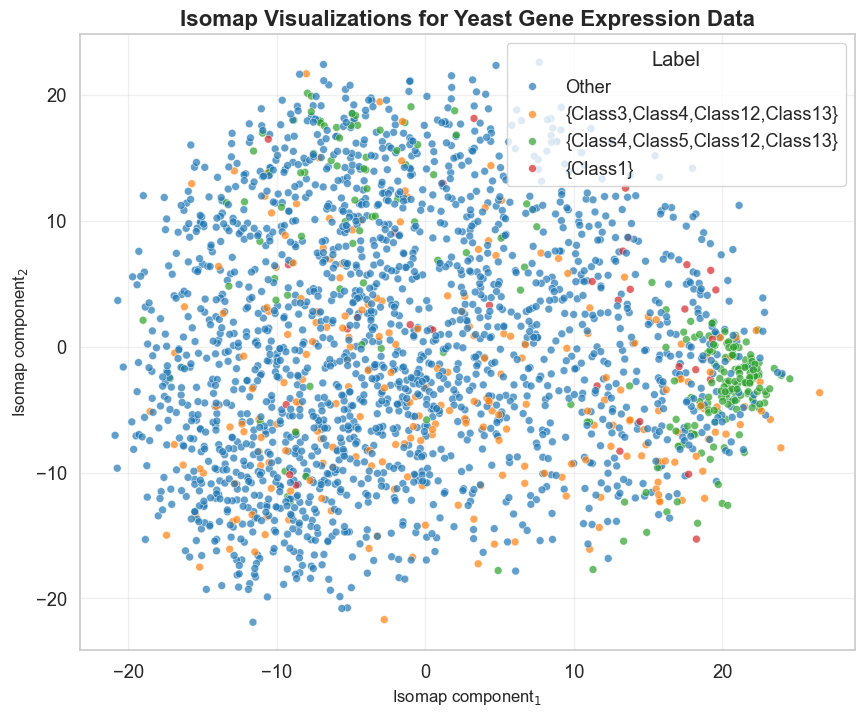

#### Interpreting the Isomap Plot

This Isomap projection of the yeast gene expression data maps each sample onto just two dimensions, trying to preserve the data's true geometric relationships as much as possible. Here’s how to read it:

- **Broad spread:** The points are scattered widely across the plot, indicating that the data is not tightly bunched into a small region.
- **Clusters:** Noticeable clusters (such as the green group) suggest some classes form cohesive groups on the manifold, while others (like the blue and orange points) are more interspersed.
- **Continuity:** The overall shape looks continuous, without sharp breaks or dramatic folds. This suggests the manifold is only moderately curved and not highly tangled or disconnected.

***

#### What This Means for Classification

The nature of the manifold has a direct impact on **how difficult it is to classify the data**:

- **If the manifold were highly twisted, folded, or fragmented**, class boundaries would be very complex and non-linear. That would make classification much tougher, especially for models that can only learn simple (linear) decision rules.
- **In this plot,** while there is clear overlap among classes and scattered regions, the underlying structure is not extremely complicated. This means classification is still challenging—because there isn’t perfect separation and there are mixed or overlapping areas—but it is not as difficult as it could be if the manifold were more complex.
- As a result, while some non-linear methods may help, the demand for extremely flexible classifiers (like deep neural networks) is less pressing than if the manifold was highly intricate. Overlap, rather than underlying manifold complexity, is the biggest obstacle in this case.

**Summary:**
- The Isomap plot suggests a moderately curved manifold for yeast gene data.
- Classification is tricky mainly due to class overlap, not because the data lives on a highly complex surface.
- More flexible models may help, but the challenge is more about separating overlapping groups than navigating a wild manifold.


### Miscellaneous

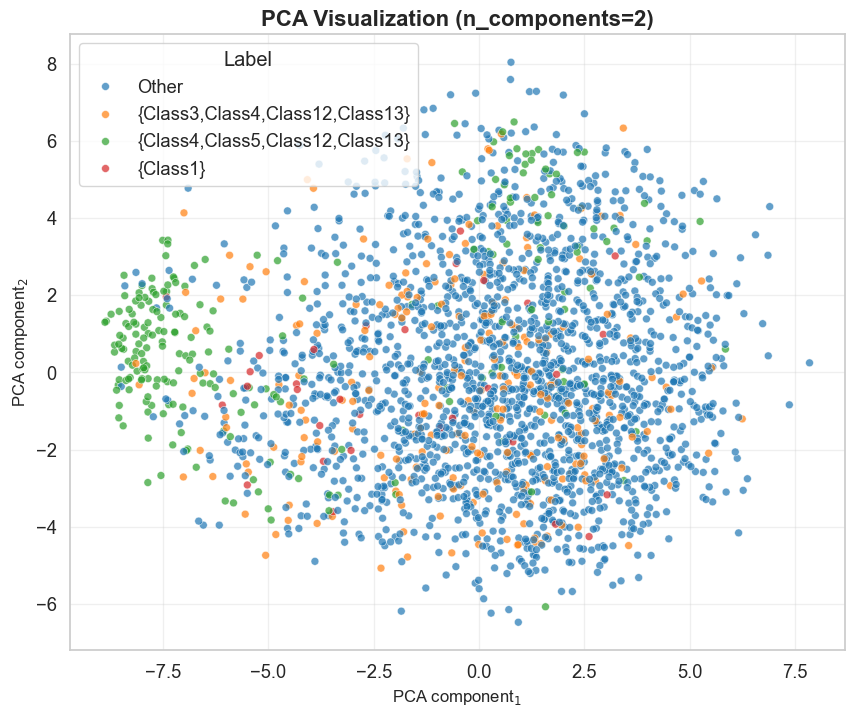

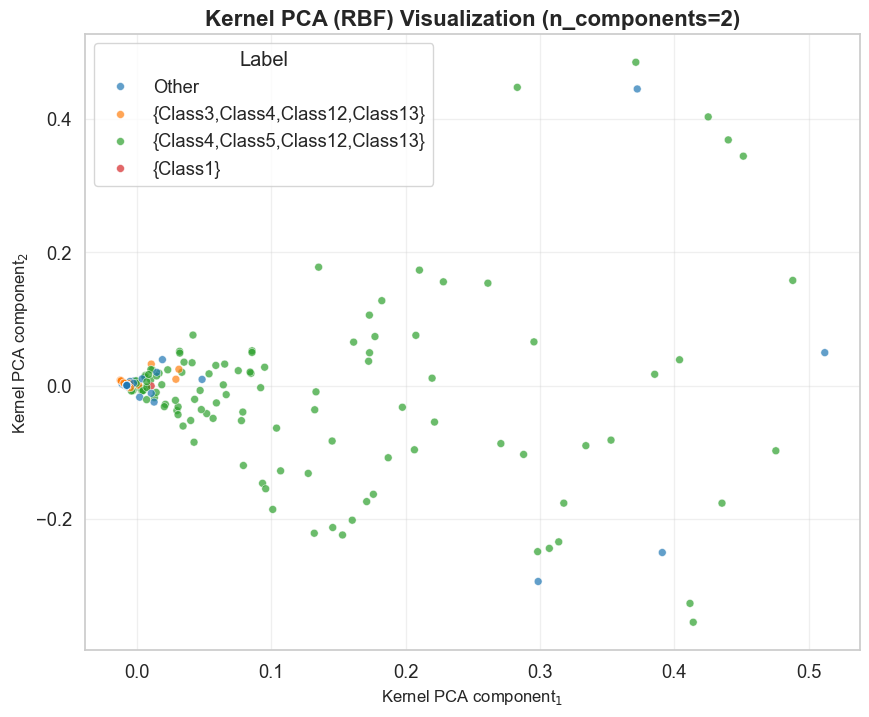

In [40]:
from sklearn.decomposition import PCA, KernelPCA

# Standard PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,8))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=y['Label'],
    alpha=0.7, s=32,
    palette="tab10"
)
plt.xlabel("PCA component$_1$", fontsize=12)
plt.ylabel("PCA component$_2$", fontsize=12)
plt.title("PCA Visualization (n_components=2)", fontsize=16, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.show()

# Kernel PCA (RBF kernel)
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.1, random_state=42)
X_kpca = kpca.fit_transform(X_scaled)

plt.figure(figsize=(10,8))
sns.scatterplot(
    x=X_kpca[:,0], y=X_kpca[:,1],
    hue=y['Label'],
    alpha=0.7, s=32,
    palette="tab10"
)
plt.xlabel("Kernel PCA component$_1$", fontsize=12)
plt.ylabel("Kernel PCA component$_2$", fontsize=12)
plt.title("Kernel PCA (RBF) Visualization (n_components=2)", fontsize=16, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.show()

The Kernel PCA (RBF) plot reveals some spread and curvature, especially for the green group. However, much of the data still overlaps in a tight cluster, suggesting that while non-linear structure exists, the main classification hurdle will be separating overlapping classes, not dealing with an extremely complex or fragmented manifold.

# Thank You!